Extended PM data
Try to extend PM data with new EBAS extract

In [1]:
import pyaerocom as pya
import os
import glob
import pandas as pd 
import datetime

In [2]:
# modules importation
from trends_functions import *
from warnings import filterwarnings
filterwarnings('ignore')

In [3]:
# computation parameters
params = get_params()

In [4]:
# run observations
# 'ang4487aer' 'od550aer' 'od550gt1aer' 'od550lt1aer' 'concpm10' 'concpm25' 'concso4' 'scatc550dryaer' 'absc550aer'
var = 'concpm10'
params['kind'] = 'obs'
fill_params(params, var)
if var in ['scatc550dryaer', 'absc550aer']:
    params['period'] = '2000-2018'
params['var'] = var
obs_source = params['source']
reader = pya.io.ReadUngridded(obs_source)
obs_data = reader.read(vars_to_retrieve=var)

In [5]:
obs_data[0].station_name

'Amberd'

Read EBAS Files

In [6]:
#read all the .nas year from IMPROVE directory
EBAS = {}
folder = os.path.join("IMPROVE-2019_partial/data/")
for root,dirs,files in os.walk(folder):
    for file in files:
        if file.endswith(".nas") and 'checkpoint' not in file:
            f=open(folder+'/'+file, 'r')
            ebas = []
            for i, line in enumerate(f):
                #print(line.split(':')[0])
                if line.split(':')[0] == 'Station name':
                    iname = i
                if line.split(':')[0] == 'Startdate':
                    idate = i
                if line.split(':')[0].split(' ')[0] == 'starttime':
                    idata = i+1
                ebas.append(repr(line))
            
            #statname
            station_name = ebas[iname].split(':',1)[1].split('\\n')[0].strip()
            #date
            strdate0 = ebas[idate].split(':',1)[1].split('\\n')[0].strip()
            yyyy, mm, dd, hh, mn, ss = int(strdate0[0:4]), int(strdate0[4:6]), int(strdate0[6:8]), int(strdate0[8:10]), int(strdate0[10:12]), int(strdate0[12:14])
            date0 = datetime.datetime(yyyy,mm,dd,hh,mn,ss)
            #data
            data = [d[1:-3].strip().replace("''","").split(' ') for d in ebas[idata:]]
            datok = []
            #check flags
            header = ebas[idata-1][0:-3].split(' ')
            if 'flag_PM10' in header and 'flag_PM2.5' in header:
                iflagpm10 = header.index('flag_PM10')
                iflagpm25 = header.index('flag_PM2.5')
            else:
                #last columns: seame flag for both
                iflagpm10 = -1
                iflagpm25 = -1
            #data
            if 'PM10' in header:
                ipm10 = header.index('PM10')
            else:
                ipm10 = -1
            if 'PM2.5' in header:
                ipm25 = header.index('PM2.5')
            else:
                ipm25 = -1
            
            
            for dat in data:
                datok.append([float(d) for d in dat if d!=''])

            #prepare db
            thead = ['datetime','concpm10','concpm25']
            tbody = []
            for dat in datok:
                dt = date0+datetime.timedelta(days = dat[0])
                #get data
                if ipm10!=-1:
                    pm10 = dat[ipm10]
                else:
                    pm10 = np.nan
                if ipm25!=-1:
                    pm25 = dat[ipm25]
                else:
                    pm25 = np.nan
                #set flag
                if dat[iflagpm10]!=0 or pm10>=999:
                    pm10 = np.nan
                if dat[iflagpm25]!=0 or pm25>=999:
                    pm25 = np.nan
                tbody.append([dt,pm10,pm25])
            
            db = pd.DataFrame(tbody, columns=thead)
            #set datetinme as proper index
            db['datetime'] = pd.to_datetime(db['datetime'])
            db.set_index('datetime', inplace=True)
            db.sort_index(inplace=True)
            #resample
            db = db.resample('M').mean()
            if station_name!=EBAS.keys():
                EBAS[station_name] = db
            else:
                EBAS[station_name] = pd.append(db)
                EBAS[station_name].sort_index(inplace=True)
            
            f.close()

Guadalupe Mountains NP
Guadalupe Mountains NP new data
Everglades National Park-Research Center (FL11)
Everglades National Park-Research Center (FL11) new data
Bosque del Apache
Bosque del Apache new data
San Gabriel
San Gabriel new data
Rocky Mountain NP
Rocky Mountain NP new data
Monture
Monture new data
Great Sand Dunes NM
Great Sand Dunes NM new data
Hells Canyon
Hells Canyon new data
Walker River Paiute Tribe
Walker River Paiute Tribe new data
Fort Peck (IMPROVE)
Fort Peck (IMPROVE) new data
Badlands NP
Badlands NP new data
Gates of the Mountains
Gates of the Mountains new data
Breton Island
Breton Island new data
Simeonof
Simeonof new data
San Gorgonio Wilderness
San Gorgonio Wilderness new data
Sac and Fox
Sac and Fox new data
Pinnacles National Monument-Bear Valley (CA66)
Pinnacles National Monument-Bear Valley (CA66) new data
Point Reyes National Seashore
Point Reyes National Seashore new data
Theodore Roosevelt National Park-Painted Canyon
Theodore Roosevelt National Park-Pai

(-10, 100)

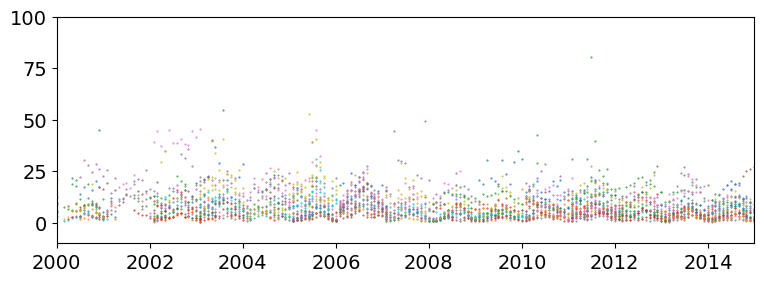

In [7]:
fig, ax = plt.subplots(figsize=(9, 3), dpi=100, facecolor='w', edgecolor='k')
keys = list(EBAS.keys())
for key in keys:
    plt.plot(EBAS[key].index,EBAS[key].values,'.', ms=0.9)
ax.set_xlim('2000-01-01','2015-01-01')
ax.set_ylim(-10,100)

In [13]:
EBAS['Fresno']

,concpm10,concpm25
datetime,,
2005-05-31,52.657333,10.494222
2005-06-30,39.296600,13.079500
2005-07-31,40.640222,30.989667
2005-08-31,29.239125,25.522250
2005-09-30,7.966000,5.347000


(0, 100)

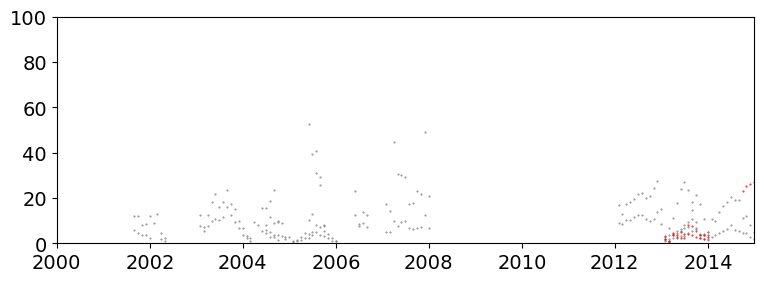

In [9]:
fig, ax = plt.subplots(figsize=(9, 3), dpi=100, facecolor='w', edgecolor='k')
obs_names = [obs.station_name for obs in obs_data]
new_stats = []
for key in keys:
    if key not in obs_names:
        new_stats.append(key)
        plt.plot(EBAS[key].index,EBAS[key].values,'.', color="red", ms=0.9)
    else:
        plt.plot(EBAS[key].index,EBAS[key].values,'.', color="gray", ms=0.9)
ax.set_xlim('2000-01-01','2015-01-01')
ax.set_ylim(0,100)